In [265]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import BaseScheduler

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [266]:
class VehicleAgent(Agent):

    def __init__(self, unique_id, model, initialLane):
        super().__init__(unique_id, model)
        self.speed = 3
        self.lane = initialLane
        self.stop = False

    # 0 es x // 1 es y
    def getFrontEmptySpaces(self):
        # Get front empty spaces
        frontEmptySpaces = 0
        for i in range(1, 4):
            if self.model.grid.is_cell_empty((self.pos[0],self.pos[1]+i)):
                frontEmptySpaces += 1
            else:
                break
        return frontEmptySpaces

    def getFrontVehicle(self):
        # Get front vehicle
        frontVehicle = None
        for i in range(1, 4):
            if not self.model.grid.is_cell_empty((self.pos[0], self.pos[1] + i)):
                frontVehicle = self.model.grid.get_cell_list_contents([(self.pos[0], self.pos[1] + i)])[0]
                break
        return frontVehicle

    def whereToChange(self):
        # Check if there is a vehicle in the next lane
        rightLane = []
        leftlane = []
        if self.model.grid.is_cell_empty((self.pos[0] + 1, self.pos[1])):
            rightLane = [self.pos[0] + 1, self.pos[1]]
        elif self.model.grid.is_cell_empty((self.pos[0] - 1, self.pos[1])):
            leftlane = [self.pos[0] - 1, self.pos[1]]
        # If right lane is empty, change to right lane
        if rightLane:
            return rightLane
        # If left lane is empty, change to left lane
        elif leftlane:
            return leftlane
        # If there is no empty lane, stay in the same lane
        else:
            return self.pos
    
    def changeLane(self, laneToChange):
        # Change lane
        self.model.grid.move_agent(self, laneToChange)
        self.lane = laneToChange[0]
        self.step(self)

    def step(self):
        # Get front empty spaces
        frontEmptySpaces = self.getFrontEmptySpaces()
        # Get front vehicle
        frontVehicle = self.getFrontVehicle()
        if frontVehicle is not None:
            if frontEmptySpaces == 2 or frontEmptySpaces == 1:
                if self.lane == 1 and frontVehicle.speed < self.speed:
                    if frontVehicle.speed == 0:
                        laneToChange = self.whereToChange()
                    if laneToChange != self.pos:
                        self.changeLane(laneToChange)
                    else:
                        self.speed = 1
            if frontEmptySpaces == 1:
                if self.lane == 1 and frontVehicle.speed < self.speed:
                    if frontVehicle.speed == 0:
                        laneToChange = self.whereToChange()
                    if laneToChange != self.pos:
                        self.changeLane(laneToChange)
                    else:
                        self.speed = 0

            if self.lane != 1 and frontVehicle.speed < self.speed:
                self.speed = frontVehicle.speed
            # Move agent
            # Check if space to move is out of bounds
            if self.pos[1] + self.speed < self.model.grid.height:
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
            else:
                self.model.grid.move_agent(self, (self.pos[0], self.pos[1] + self.speed))
        else:
             if self.pos[1] + self.speed < self.model.grid.height:
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
             else:
                # Move agent
                 self.model.grid.move_agent(self, (self.pos[0], self.pos[1] + self.speed))

In [267]:
def getGrid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (content, x, y) in model.grid.coord_iter():
        if model.grid.is_cell_empty((x,y)):
            grid[x][y] = 0
        else:
            grid[x][y] = 1
    return grid

In [278]:
class HighwayModel(Model):

    def __init__(self):
        self.numAgents = 1000
        self.movimientos = 0
        self.numAgentsCreated = 0
        self.grid = SingleGrid(3,183,False)
        self.schedule = BaseScheduler(self)
        self.datacollector = DataCollector(model_reporters={"Grid":getGrid})

        #Creación y posicionamiento del primer agente de la simulación
        # def __init__(self, unique_id, model, initialLane):
        # initialRail = np.random.choice([0,1,2])
        # car = VehicleAgent(self.numAgentsCreated,self,initialRail)
        # self.grid.place_agent( car,(initialRail,0) )
        # self.schedule.add(car)
        # self.numAgentsCreated += 1 

    def step(self):
        initialRail = np.random.choice([0,1,2])
        car = VehicleAgent(self.numAgentsCreated,self,initialRail)
        self.grid.place_agent( car,(initialRail,0) )
        self.schedule.add(car)
        self.numAgentsCreated += 1 
        self.datacollector.collect(self)
        self.schedule.step()
        self.movimientos += 1
        print(self.movimientos)
        #Creación de todos los agentes de la simulación
        # if self.numAgentsCreated < self.numAgents and self.numAgentsCreated >= 1:
        #     initialRail = np.random.choice([0,1,2])
        #     car = VehicleAgent(self.numAgentsCreated,self,initialRail)
        #     self.grid.place_agent( car,(initialRail,0) )
        #     self.schedule.add(car)
        #     self.numAgentsCreated += 1 

In [283]:
MAX_ITER = 61

start_time = time.time()

model = HighwayModel()

for i in range(MAX_ITER):
    model.step()

print("Tiempo de ejecución: ", str(datetime.timedelta(seconds=(time.time()-start_time))))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


IndexError: list index out of range

In [280]:
all_grid = model.datacollector.get_model_vars_dataframe()
#print(all_grid)

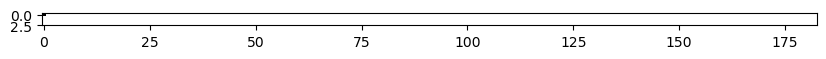

In [281]:
fig, axs = plt.subplots(figsize=(10,10))
axs.set_xticks = ([])
axs.set_yticks = ([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig,animate,frames=MAX_ITER)

In [282]:
anim